# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("/content/drive/MyDrive/ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)
print(testFaces.shape,testLabels.shape)

(360, 112, 92) (360,)
(40, 112, 92) (40,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.
1. Find covariance matrix of the features.
2. Find the eigen values and corresponding eigen vectors of covariance matrix.
3. Find the K maximum eigen vectors (with respect to the eigen values ).
4. Those eigen vectors are our required principal components.

In [ ]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """

    # your code here
    X_mean = np.mean(X,axis=0)

    X = (X - X_mean)/np.std(X)

    # N = X.shape[0]

    # 1) Find covariance matrix of all the features
    cov_matrix = np.cov(X.T)

    # 2) finding eigen values, eigen vectors
    eig_vals,eig_vecs = np.linalg.eigh(cov_matrix)

    # 3) find top numComponents eigen vectors which are our required principal components

    # sort the eigenvalues in descending order
    sorted_index = np.argsort(eig_vals)[::-1]
    # gives the indices in sorted order

    # using the order to sort the eigen vectors
    sorted_eigenvectors = eig_vecs[:,sorted_index]

    # getting the top k eigen_vectors
    princ_comps = sorted_eigenvectors[:,:numComponents]

    return eig_vecs,princ_comps,X_mean

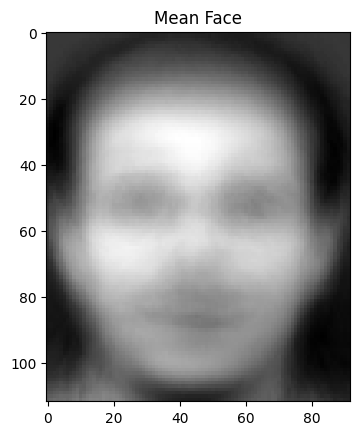

In [ ]:
numComponents = 100
trainFaces=trainFaces.reshape(360,-1)   # flattening images
eigen_vectors,pca_components,X_mean = principalComponentAnalysis(trainFaces,numComponents)
images_shape=(112,92)
plt.imshow(X_mean.reshape(images_shape), cmap='gray')
plt.title("Mean Face")
plt.show()

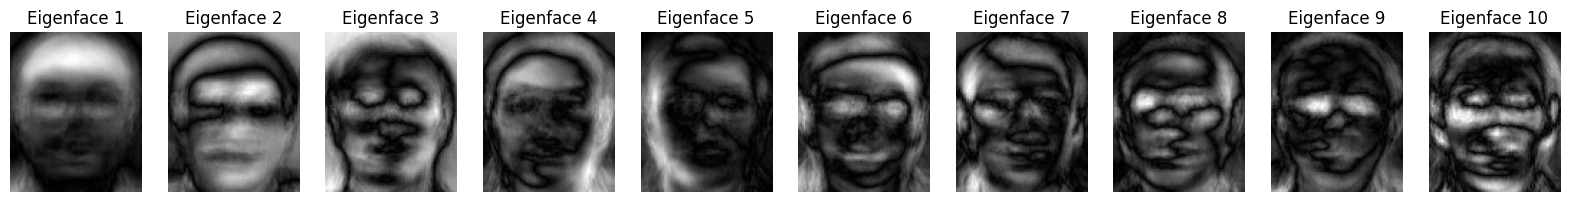

In [ ]:
# plot the eigen faces
%matplotlib inline
def plot_faces():
  fig, axes = plt.subplots(1, min(10,numComponents), figsize=(20, 4))
#   eigenFaces = []
  for i in range(min(10,numComponents)):
    eigenface = (pca_components[:,i]).reshape(images_shape)
    # Plot the eigenface
    eigenface=np.abs(eigenface)
    # eigenFaces.append(eigenface)
    axes[i].imshow(eigenface, cmap='gray')
    axes[i].set_title("Eigenface {}".format(i+1))
    axes[i].axis('off')
  plt.show()
plot_faces()

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [ ]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """
    # initialize mean face as the result
    result = meanFace

    s = testFace-meanFace

    projections=np.dot(s,eigenFaces)

    recons = meanFace + np.dot(projections, eigenFaces.T)

    return recons


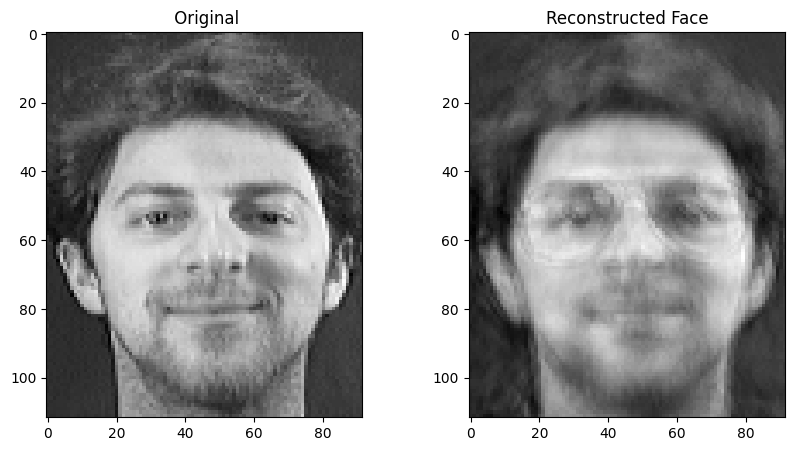

In [ ]:
# plot recontructions here
%matplotlib inline
testFaces=np.array(testFaces)
testFaces=testFaces.reshape(40,-1)
newFaces=[]
for testFace in testFaces:
    # print(testFace.shape,X_mean.shape,pca_components.shape)
    newFace=imageReconstruction(testFace,pca_components,X_mean)
    newFaces.append(newFace)
reshaped_testFaces = [face.reshape(images_shape) for face in testFaces]
newFaces = [face.reshape(images_shape) for face in newFaces]

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

# Plot original face
axes[0].imshow(reshaped_testFaces[4], cmap='gray')
axes[0].set_title(" Original")


# Plot reconstructed face
axes[1].imshow(newFaces[4], cmap='gray')
axes[1].set_title("Reconstructed Face")

plt.show()

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

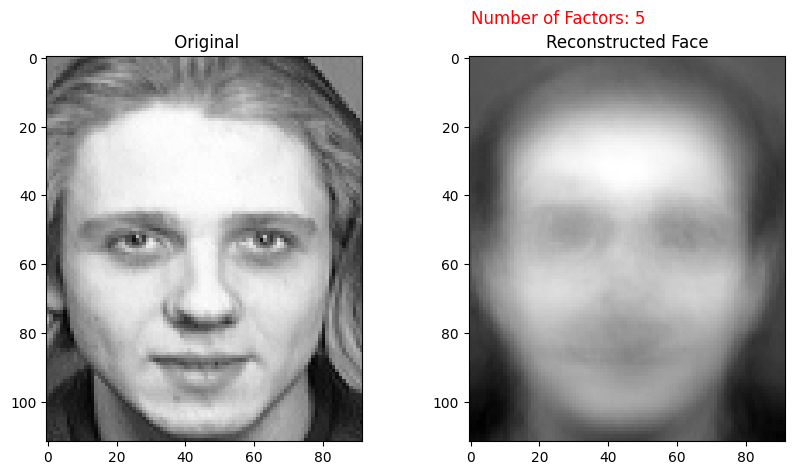

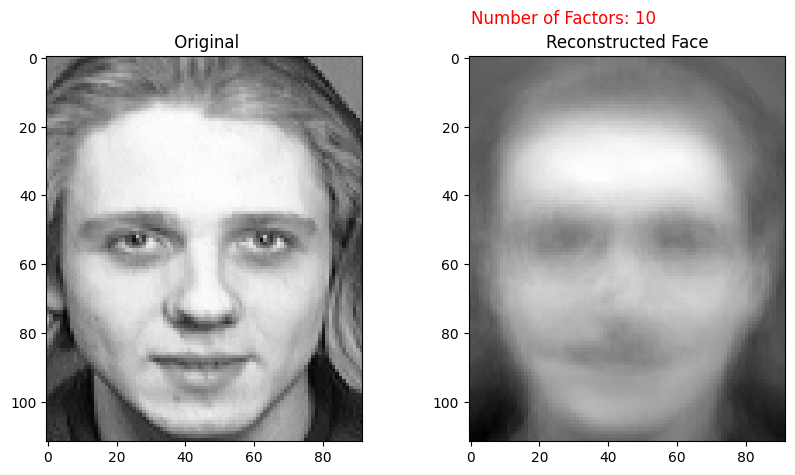

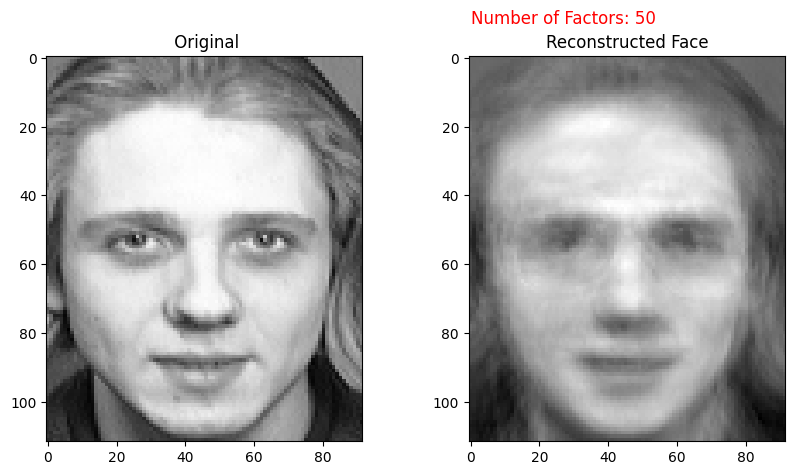

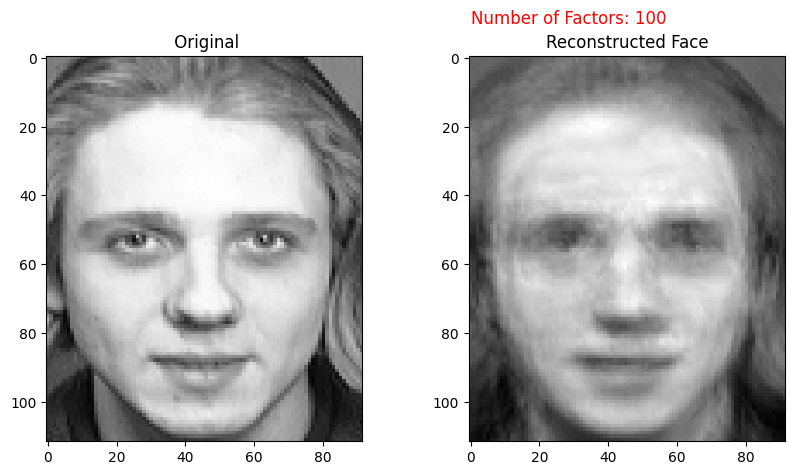

In [ ]:
%matplotlib inline
pc=[5,10,50,100]
def displayNfactors():
    for i in pc:
        # Reconstruct the face using i features
        newFace=imageReconstruction(testFaces[30],pca_components[:,:i],X_mean)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

        # Plot original face
        axes[0].imshow(testFaces[30].reshape(images_shape), cmap='gray')
        axes[0].set_title(" Original")

        # Plot reconstructed face
        axes[1].imshow(newFace.reshape(images_shape), cmap='gray')
        axes[1].set_title("Reconstructed Face")
        axes[1].text(0, -10, "Number of Factors: {}".format(i), fontsize=12, ha='left', color='red')


    # your code here

    return None
displayNfactors()

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [ ]:
def getClass(test_image, eigenvectors, mean_face, X_train, y_train):
    """
    Arguments:
    1. Test image
    2. Eigenvectors
    3. Mean Eigen Face
    4. Training Set(X_train,y_train)

    The function must return the following:
    1. image with smallest error
    2. error value
    3. prediction class
    """

    # your code here
    # Project test image onto eigenface space
    test_image_coeffs = np.dot(eigenvectors.T, test_image - mean_face)

    # variables for tracking the image with the smallest error
    smallest_error_image = None
    smallest_error = float('inf')
    prediction_class = None

    # Loop through each training image
    for i, train_image in enumerate(X_train):
        # Project training image onto eigenface space
        train_image_coeffs = np.dot(eigenvectors.T, train_image - mean_face)

        # Compute reconstruction error (Euclidean distance) between test and training image coefficients
        error = np.linalg.norm(train_image_coeffs - test_image_coeffs)

        # Update smallest error and corresponding image
        if error < smallest_error:
            smallest_error = error
            smallest_error_image = train_image
            prediction_class = y_train[i]

    return smallest_error_image, smallest_error, prediction_class
# smallest_error_image,smallest_error,prediction_class = getClass(testFaces[0],pca_components,X_mean,trainFaces,trainLabels)

Iterate through all the images in the test data and test the accuracy by taking different number of components

In [ ]:
from sklearn.metrics import accuracy_score
components = [3,5,10,20,30,40,50]
mse = []
accuracies=[]
for numComponents in components:
     # your code here
     predictions=[]
     errors=[]
     for testFace in testFaces:
        error_image,error,prediction_class=getClass(testFace,pca_components[:,:numComponents],X_mean,trainFaces,trainLabels)
        predictions.append(prediction_class)
        errors.append(error)
     mse.append(np.mean(np.array(errors) ** 2))
     accuracies.append(accuracy_score(testLabels,predictions)*100)
print(accuracies)

[65.0, 92.5, 92.5, 97.5, 97.5, 95.0, 95.0]


Plot Number of eigenvectors vs Mean Square Error

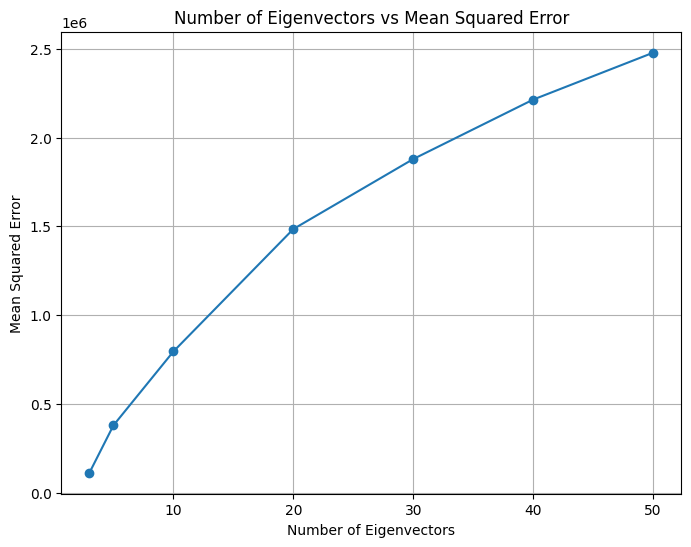

In [ ]:
# your code here

# Plot
plt.figure(figsize=(8, 6))
plt.plot(components, mse, marker='o', linestyle='-')
plt.title('Number of Eigenvectors vs Mean Squared Error')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

Plot Number of eigenvectors vs Logarithmic Mean Square Error

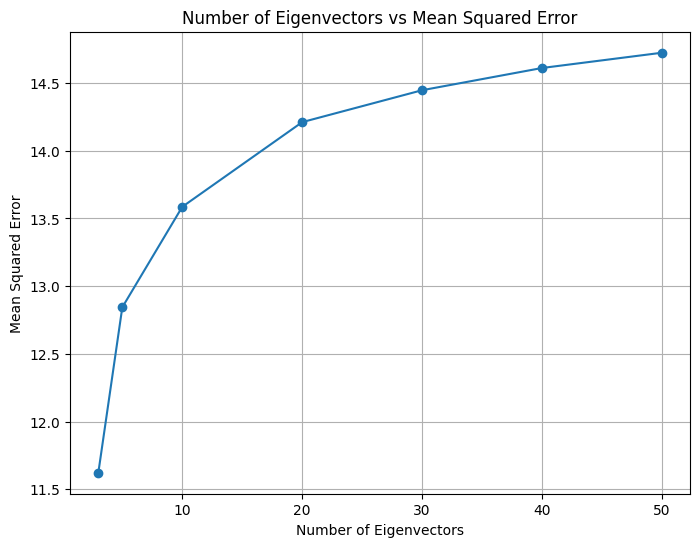

In [ ]:
# your code here
plt.figure(figsize=(8, 6))
plt.plot(components, np.log(mse), marker='o', linestyle='-')
plt.title('Number of Eigenvectors vs Mean Squared Error')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()